In [1]:
import tensorflow as tf

In [2]:
!ls pubmed-rct/

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

dev.txt
test.txt
train.zip


In [6]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [7]:
import os
filenames = [data_dir + filenames for filenames in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [8]:
def get_lines(filename):
  with open(filename, 'r') as f:
    return f.readlines()

In [9]:
lines = get_lines(data_dir+'train.txt')
lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
def preprocess_text(filename):
  
  input_lines = get_lines(filename) # get all the lines from the filename

  abstract_lines = '' # create an empty abstract
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ''
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split)
        abstract_samples.append(line_data)
    
    else:
      abstract_lines += line
  return abstract_samples

In [11]:
%%time
train_samples = preprocess_text(data_dir + 'train.txt')
val_samples = preprocess_text(data_dir + 'dev.txt')
test_samples = preprocess_text(data_dir + 'test.txt')

Wall time: 648 ms


In [12]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12


In [151]:
test_df.head()

,target,text,number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,9
1,RESULTS,a post hoc analysis was conducted with the use...,1,9
2,RESULTS,liver function tests ( lfts ) were measured at...,2,9
3,RESULTS,survival analyses were used to assess the asso...,3,9
4,RESULTS,the percentage of patients with abnormal lfts ...,4,9


In [14]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

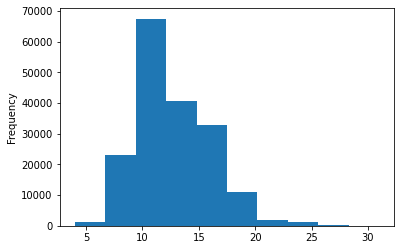

In [15]:
train_df.total_lines.plot.hist()

In [16]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

In [18]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [19]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ('tf-idf', TfidfVectorizer()),
                    ('clf', MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [22]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def evaluation_metrics(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

  return {
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1-score': fscore
  }

In [24]:
baseline_results = evaluation_metrics(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1-score': 0.6989250353450294}

## Preparing our data for deep sequence model

In [25]:
import numpy as np
from tensorflow.keras import layers

In [26]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [27]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len


26.338269273494777

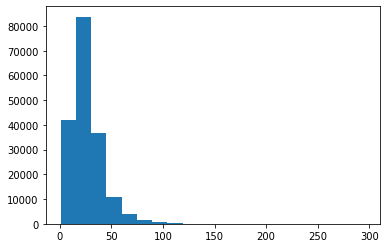

In [28]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [29]:
# How long of a setnence lenght covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [30]:
max(sent_lens)

296

## Create a text vectorizer layer

In [31]:
max_tokens = 68000

In [32]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [33]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                   output_sequence_length=output_seq_len)

In [34]:
text_vectorizer.adapt(train_sentences)

In [36]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
their consumption has been associated with higher cholesterol content in high-density lipoproteins ( hdl ) .

Length of text: 16

Vectorized text: [[ 120  419  139  167   81    7   82  573 1014    5 3137 5651 1718    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [37]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [38]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

## Create custom text embedding

In [39]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                              output_dim=128,
                              mask_zero=True,
                              name='token_embedding')

In [40]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 their consumption has been associated with higher cholesterol content in high-density lipoproteins ( hdl ) .

Sentence after vectorization (before embedding):
 [[ 120  419  139  167   81    7   82  573 1014    5 3137 5651 1718    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.01935601  0.03911947 -0.00530108 ...  0.00101648 -0.04045786
   -0.04039962]
  [-0.00915922  0.04302326  0.03565237 ... -0.03504927 -0.00548596
    0.04760225]
  [ 0.02534871  0.04194052  0.00222536 ... -0.00514419  0.00971
   -0.02779583]
  ...
  [-0.00018378  0.01085307  0.03189656 ...  0.02429165  0.03011018
   -0.01488366]
  [-0.00018378  0.01085307  0.03189656 ...  0.02429165  0.03011018
   -0.01488366]
  [-0.00018378  0.01085307  0.03189656 ...  0.02429165  0.03011018
   -0.0148

## Creating datasets with tf.data API

In [46]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [47]:
# Take the tensorslice datasets and turn it into prefetch datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

# Model 1: Conv1D with token embeddings

In [55]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', name='conv1d_layer')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax' ,name='output_layer')(x)
model_1 = tf.keras.Model(inputs,outputs)

model_1.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [56]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_layer (Conv1D)       (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 output_layer (Dense)        (None, 5)                 325 

In [52]:
len(train_dataset)

5627

In [57]:
history_model_1 = model_1.fit(train_dataset,
                             steps_per_epoch=int(0.1 * len(train_dataset)),
                             epochs=3,
                             validation_data=valid_dataset,
                             validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/10
562/562 [==============================] - 4s 7ms/step - loss: 0.9134 - accuracy: 0.6336 - val_loss: 0.6727 - val_accuracy: 0.7427
Epoch 2/10
562/562 [==============================] - 4s 6ms/step - loss: 0.6490 - accuracy: 0.7593 - val_loss: 0.6241 - val_accuracy: 0.7696
Epoch 3/10
562/562 [==============================] - 4s 6ms/step - loss: 0.6173 - accuracy: 0.7732 - val_loss: 0.5958 - val_accuracy: 0.7769
Epoch 4/10
562/562 [==============================] - 4s 7ms/step - loss: 0.5924 - accuracy: 0.7846 - val_loss: 0.5793 - val_accuracy: 0.7793
Epoch 5/10
562/562 [==============================] - 4s 6ms/step - loss: 0.5994 - accuracy: 0.7854 - val_loss: 0.5726 - val_accuracy: 0.7912
Epoch 6/10
562/562 [==============================] - 4s 6ms/step - loss: 0.5889 - accuracy: 0.7863 - val_loss: 0.5623 - val_accuracy: 0.7949
Epoch 7/10
562/562 [==============================] - 4s 6ms/step - loss: 0.5681 - accuracy: 0.7945 - val_loss: 0.5545 - val_accuracy: 0.8012
Epoch 

In [58]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5349 - accuracy: 0.8068


[0.5349441170692444, 0.8068317174911499]

In [59]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[5.3648823e-01, 8.9922868e-02, 1.1503246e-01, 1.9567278e-01,
         6.2883690e-02],
        [5.6297517e-01, 2.3481089e-01, 7.4711009e-03, 1.7171386e-01,
         2.3029046e-02],
        [1.9076075e-01, 4.9389573e-03, 1.5409724e-03, 8.0273759e-01,
         2.1725638e-05],
        ...,
        [1.7323295e-05, 1.4807053e-04, 2.7032541e-03, 2.1868083e-05,
         9.9710947e-01],
        [1.3784434e-01, 4.2085397e-01, 1.4578992e-01, 6.6415712e-02,
         2.2909604e-01],
        [2.1171300e-02, 9.5534432e-01, 1.4654767e-02, 6.3727010e-04,
         8.1923297e-03]], dtype=float32),
 (30212, 5))

In [60]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [64]:
model_1_results = evaluation_metrics(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 0.8068317224943731,
 'precision': 0.8028958488848327,
 'recall': 0.8068317224943731,
 'f1-score': 0.8033869974425141}

# Model_2: Feature extraction with pretrained embeddings

In [63]:
import tensorflow_hub as hub

In [71]:
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
#                                        trainable=False,
#                                         input_shape=[],
#                                        dtype=tf.string,
                                       name='USE')

In [77]:
random_train_sentence = random.choice(train_sentences)
print(f'Random train sentence: \n{random_train_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding:\n{use_embedded_sentence[0][:30]}')
print(f'Length of sentence embedding:\n{len(use_embedded_sentence[0])}')

Random train sentence: 
larger , controlled studies are needed to evaluate the efficacy of chromium treatment in this patient population .
Sentence after embedding:
[-0.0116039  -0.00277928 -0.01129138 -0.02133876 -0.02306652 -0.06549935
  0.05915339 -0.00047198  0.04982203 -0.02230037  0.08701648 -0.02619959
  0.08481243  0.04584644 -0.06015033  0.02789671 -0.09014876  0.00790799
 -0.05594796 -0.06865301 -0.07136767 -0.02598707 -0.04939269 -0.07394738
  0.01567831  0.0148856   0.0400087  -0.0178933  -0.06157394  0.04515227]
Length of sentence embedding:
512


# Building and fitting an NLP feature extraction model using pretrained embeddings 

In [79]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name='model_2_USE')

model_2.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [80]:
history_model_2 = model_2.fit(train_dataset,
                             epochs=3,
                             steps_per_epoch=int(0.1 * len(train_dataset)),
                             validation_data=valid_dataset,
                             validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 17ms/step - loss: 0.9141 - accuracy: 0.6509 - val_loss: 0.7960 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7693 - accuracy: 0.7022 - val_loss: 0.7556 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7535 - accuracy: 0.7116 - val_loss: 0.7394 - val_accuracy: 0.7114


In [81]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.7422 - accuracy: 0.7120


[0.7421735525131226, 0.7120349407196045]

In [82]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.6234784e-01, 3.1994414e-01, 3.0260514e-03, 2.0642936e-01,
        8.2526468e-03],
       [3.0707809e-01, 5.3930008e-01, 4.3409877e-03, 1.4687392e-01,
        2.4068623e-03],
       [2.2044598e-01, 1.6995178e-01, 2.4081463e-02, 5.4224908e-01,
        4.3271650e-02],
       ...,
       [1.7931287e-03, 6.3505070e-03, 5.2276008e-02, 8.8182645e-04,
        9.3869853e-01],
       [3.4150588e-03, 4.7175337e-02, 1.7580684e-01, 1.3045900e-03,
        7.7229822e-01],
       [1.7329864e-01, 2.7837518e-01, 4.8972866e-01, 6.4321053e-03,
        5.2165471e-02]], dtype=float32)

In [83]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 4, 2, 2, 4, 4, 1], dtype=int64)>

In [84]:
model_2_results = evaluation_metrics(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 0.7120349529988084,
 'precision': 0.7121872039859143,
 'recall': 0.7120349529988084,
 'f1-score': 0.7091283077915083}

# Model_3:- Conv1D with character embeddings

In [85]:
# creating a character level tokenizer
def split_chars(text):
    return " ".join(list(text))

In [86]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:10]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [97]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

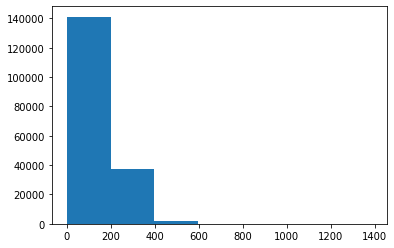

In [88]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [98]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [99]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [100]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                   output_sequence_length=output_seq_char_len,
                                   name='char_vectorizer')

In [101]:
char_vectorizer.adapt(train_chars)

In [102]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [103]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 w e   d e s c r i b e   a   c l i n i c a l   d e c i s i o n   s u p p o r t   s y s t e m   t o   i m p r o v e   g e n e r a l   p r a c t i t i o n e r   (   g p   )   a d h e r e n c e   t o   a c o v e   q u a l i t y   i n d i c a t o r s   a n d   a   p r o t o c o l   f o r   i n v e s t i g a t i n g   i m p a c t   o n   g p s   '   a d h e r e n c e   t o   t h e   r u l e s   .

Length of random_train_chars: 165

Vectorized chars:
 [[20  2 10  2  9 11  8  4 22  2  5 11 12  4  6  4 11  5 12 10  2 11  4  9
   4  7  6  9 16 14 14  7  8  3  9 19  9  3  2 15  3  7  4 15 14  8  7 21
   2 18  2  6  2  8  5 12 14  8  5 11  3  4  3  4  7  6  2  8 18 14  5 10
  13  2  8  2  6 11  2  3  7  5 11  7 21  2 26 16  5 12  4  3 19  4  6 10
   4 11  5  3  7  8  9  5  6 10  5 14  8  7  3  7 11  7 12 17  7  8  4  6
  21  2  9  3  4 18  5  3  4  6 18  4 15 14  5 11  3  7  6 18 14  9  5 10
  13  2  8  2  6 11  2  3  7  3 13  2  8 16 12  2  9  0  0  0  0  0  0  0
   0  0  0  0  0

# Creating a character level embedding

In [104]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                             output_dim=25,
                             mask_zero=True,
                             name='char_level_embedding')

In [106]:
print(f'Characterized text:\n{random_train_chars}')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars (after vectorization and embedding):\n{char_embed_example}')
print(f'Character embedding shape:\n{char_embed_example.shape}')

Characterized text:
w e   d e s c r i b e   a   c l i n i c a l   d e c i s i o n   s u p p o r t   s y s t e m   t o   i m p r o v e   g e n e r a l   p r a c t i t i o n e r   (   g p   )   a d h e r e n c e   t o   a c o v e   q u a l i t y   i n d i c a t o r s   a n d   a   p r o t o c o l   f o r   i n v e s t i g a t i n g   i m p a c t   o n   g p s   '   a d h e r e n c e   t o   t h e   r u l e s   .
Embedded chars (after vectorization and embedding):
[[[-0.03891457  0.04695174  0.04323143 ...  0.00597018 -0.03887375
    0.02754233]
  [-0.00866581  0.04918741  0.01707627 ...  0.01046065  0.0097838
    0.03377923]
  [ 0.02307617  0.04192961 -0.01784647 ... -0.02596536 -0.03934935
   -0.04932625]
  ...
  [ 0.04871284 -0.04057716  0.0059142  ... -0.01753213  0.03530577
   -0.00701525]
  [ 0.04871284 -0.04057716  0.0059142  ... -0.01753213  0.03530577
   -0.00701525]
  [ 0.04871284 -0.04057716  0.0059142  ... -0.01753213  0.03530577
   -0.00701525]]]
Character embedding shape:
(1

In [107]:
inputs = layers.Input(shape=[], dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [110]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [112]:
history_model_3 = model_3.fit(train_char_dataset,
                             steps_per_epoch=int(0.1 * len(train_char_dataset)),
                             epochs=3,
                             validation_data=valid_char_dataset,
                             validation_steps=int(0.1 * len(valid_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2609 - accuracy: 0.5011 - val_loss: 1.0505 - val_accuracy: 0.5934
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0084 - accuracy: 0.5954 - val_loss: 0.9355 - val_accuracy: 0.6303
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9275 - accuracy: 0.6378 - val_loss: 0.8630 - val_accuracy: 0.6639


In [113]:
model_3.evaluate(valid_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8887 - accuracy: 0.6539


[0.8887218832969666, 0.6538792252540588]

In [114]:
# Prediction probability
model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_pred_probs

array([[0.14796291, 0.5034218 , 0.02704256, 0.28896493, 0.03260782],
       [0.18752368, 0.6420189 , 0.01839361, 0.11631263, 0.03575125],
       [0.05551464, 0.27036276, 0.26848382, 0.33178592, 0.07385288],
       ...,
       [0.0109396 , 0.04538607, 0.05796779, 0.05412629, 0.8315802 ],
       [0.0206554 , 0.10843294, 0.4121311 , 0.03838384, 0.42039672],
       [0.35553974, 0.3899422 , 0.13606003, 0.094422  , 0.02403604]],
      dtype=float32)

In [115]:
# Convert probabilites into labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 1, 3, 2, 2, 2, 4, 1, 4, 1], dtype=int64)>

In [116]:
model_3_results = evaluation_metrics(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 0.6538792532768436,
 'precision': 0.6470778349041529,
 'recall': 0.6538792532768436,
 'f1-score': 0.6445506263559935}

# Model_4: Combining pretrained token embeddings + character embeddings (hybrid embedding layers)

* Create a token-level embedding model 
* Create a character-level embedding model
* Combine 1 & 2 with a concatenate
* Build a series of output layers on top of model 3
* Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [117]:
# Setup a token-level model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                            outputs=token_outputs)

In [118]:
# Setup a char-level model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)

In [119]:
# Concatenate a token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                 char_model.output])

In [120]:
# Create the output layers, adding dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

In [122]:
# Construct model with char and token input
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                        outputs=output_layer,
                        name='model_4_token_and_char_embeddings')

In [123]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   [

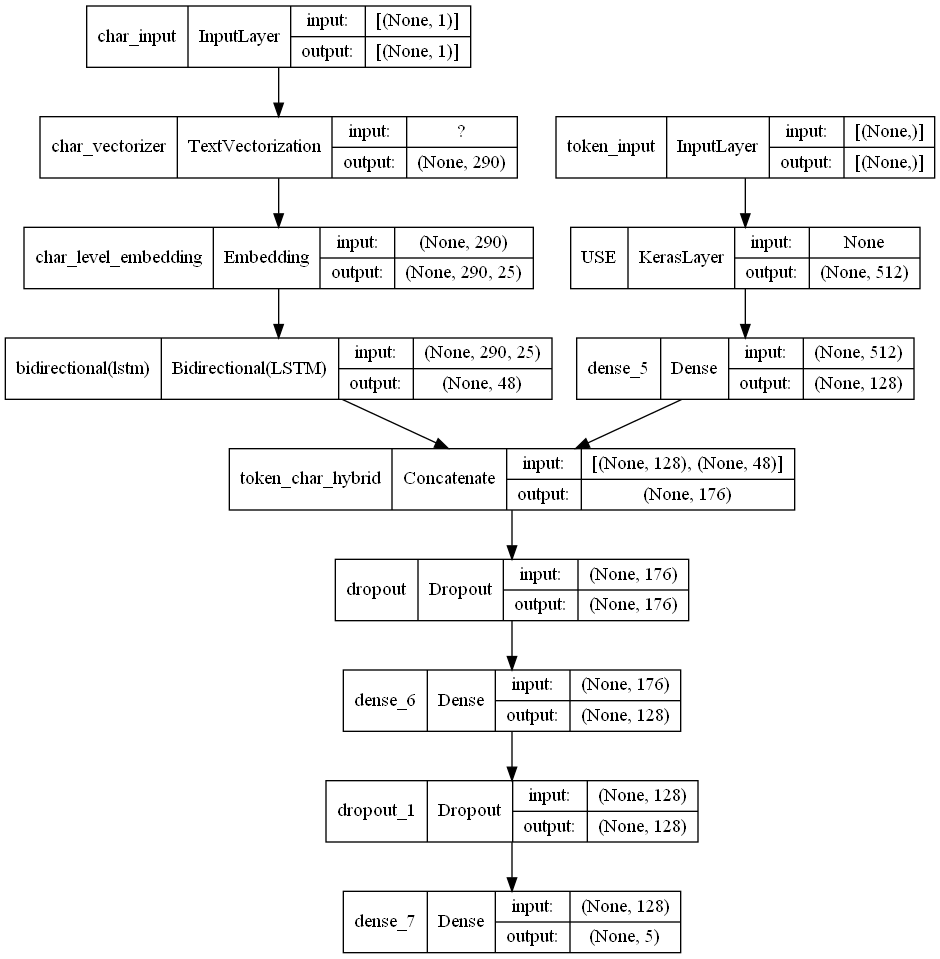

In [126]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [139]:
model_4.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# Combining token and character data into tf.data

In [130]:
# Combine char and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [131]:
train_char_token_dataset

<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>

In [132]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [133]:
val_char_token_dataset

<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>

# Fitting a model on character-level token sequences

In [140]:
history_model_4 = model_4.fit(train_char_token_dataset,
                             steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                             epochs=3,
                             validation_data=val_char_token_dataset,
                             validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 44s 69ms/step - loss: 0.9537 - accuracy: 0.6232 - val_loss: 0.7821 - val_accuracy: 0.6932
Epoch 2/3
562/562 [==============================] - 33s 59ms/step - loss: 0.8024 - accuracy: 0.6911 - val_loss: 0.7223 - val_accuracy: 0.7221
Epoch 3/3
562/562 [==============================] - 27s 49ms/step - loss: 0.7742 - accuracy: 0.7026 - val_loss: 0.6965 - val_accuracy: 0.7364


In [141]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 57s 60ms/step - loss: 0.6959 - accuracy: 0.7365


[0.6958727836608887, 0.7364623546600342]

In [142]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.3214044e-01, 3.0494869e-01, 3.6928819e-03, 2.5047913e-01,
        8.7388176e-03],
       [3.2899252e-01, 5.0009090e-01, 2.5934253e-03, 1.6537926e-01,
        2.9439242e-03],
       [3.1451085e-01, 1.3970359e-01, 5.0343264e-02, 4.6720615e-01,
        2.8236222e-02],
       ...,
       [7.3542242e-04, 1.0276352e-02, 6.7167625e-02, 3.7309705e-04,
        9.2144746e-01],
       [5.5744192e-03, 3.1431220e-02, 3.4209669e-01, 3.4801716e-03,
        6.1741751e-01],
       [3.9617261e-01, 3.2961369e-01, 1.7276634e-01, 5.4641847e-02,
        4.6805479e-02]], dtype=float32)

In [143]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0], dtype=int64)>

In [144]:
model_4_results = evaluation_metrics(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 0.736462332847875,
 'precision': 0.7369998119520543,
 'recall': 0.736462332847875,
 'f1-score': 0.734331386209123}

# Model_5:- Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [145]:
train_df.head()

,target,text,number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12


In [148]:
train_df['number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

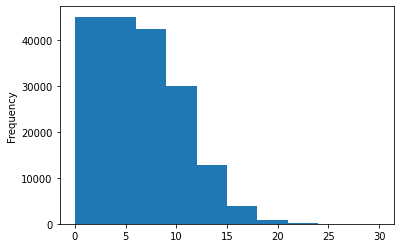

In [149]:
train_df.number.plot.hist()

In [153]:
train_line_numbers_one_hot = tf.one_hot(train_df['number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['number'].to_numpy(), depth=15)

In [154]:
train_line_numbers_one_hot[:10],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [155]:
train_df['total_lines'].value_counts()

12    24468
11    23639
13    22113
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: total_lines, dtype: int64

<AxesSubplot:ylabel='Frequency'>

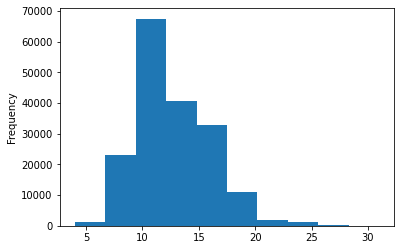

In [156]:
train_df.total_lines.plot.hist()

In [158]:
np.percentile(train_df.total_lines, 97)

20.0

In [159]:
# Use tensorflow to create one-hot encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

In [164]:
train_total_lines_one_hot[:0]

<tf.Tensor: shape=(0, 20), dtype=float32, numpy=array([], shape=(0, 20), dtype=float32)>

# Building a tribrid model

1) Create a token-level model

2) Create a character-level model

3) Create a model for 'line_numbers' feature

4) Create a model for 'total_lines' feature

5) Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate

6) Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate

7) Create an output layer to accept the tribrid embedding and output label probabilites

8) Combine the inputs of 1,2,3,4 and outputs of into a tf.keras.Model

In [224]:
# Create a token-level model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu', name='token_outputs')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                            outputs=token_outputs)

In [225]:
# Create a character-level model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24), name='char_lstm_layer')(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)

In [226]:
# Model for line_numbers feature
line_numbers_input = layers.Input(shape=(15,),dtype=tf.float32, name='line_numbers_input')
x = layers.Dense(32, activation='relu')(line_numbers_input)
line_numbers_model = tf.keras.Model(inputs=line_numbers_input,
                                   outputs=x)

In [227]:
# Model for Total_lines feature
total_lines_input = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
y = layers.Dense(32, activation='relu')(total_lines_input)
total_lines_model = tf.keras.Model(inputs=total_lines_input,
                                  outputs=y)

In [228]:
# Combine the token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='token_char_embeddings')([token_model.output,
                                                                       char_model.output])

In [229]:
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

In [230]:
# Combine positional embedding with hybrid embeddings
tribrid_embeddings = layers.Concatenate(name='tribrid_embeddings')([line_numbers_model.output,
                                                                   total_lines_model.output,
                                                                   z])

In [231]:
# Output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

In [232]:
# Putting it all together
model_5 = tf.keras.Model(inputs=[token_model.inputs,
                                char_model.inputs,
                                line_numbers_model.inputs,
                                total_lines_model.inputs],
                        outputs=output_layer,
                        name='model_5_tribrid_model')

In [233]:
model_5.summary()

Model: "model_5_tribrid_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_input

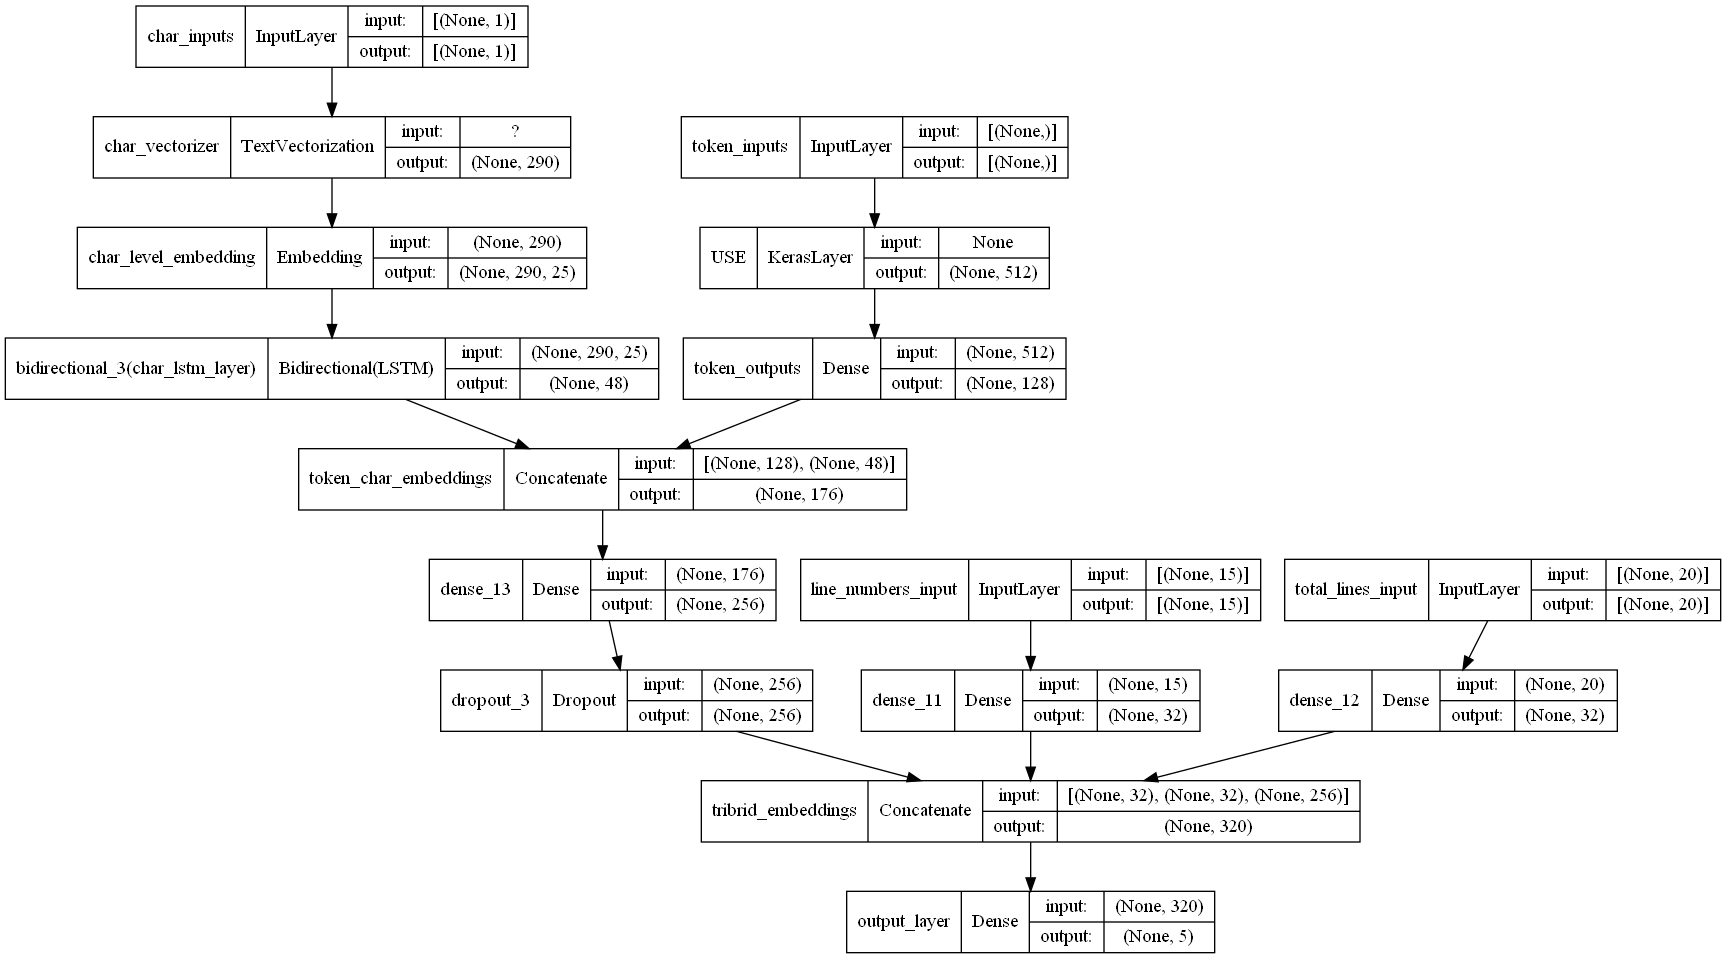

In [205]:
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [234]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# Create tribrid embedding dataset using tf.data

In [177]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_sentences,
                                                               train_chars,
                                                               train_line_numbers_one_hot,
                                                               train_total_lines_one_hot))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [178]:
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_sentences,
                                                             val_chars,
                                                             val_line_numbers_one_hot,
                                                             val_total_lines_one_hot))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [179]:
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset shapes: (((None,), (None,), (None, 15), (None, 20)), (None, 5)), types: ((tf.string, tf.string, tf.float32, tf.float32), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,), (None, 15), (None, 20)), (None, 5)), types: ((tf.string, tf.string, tf.float32, tf.float32), tf.float64)>)

In [235]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                             epochs=3,
                             steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                             validation_data=val_char_token_pos_dataset,
                             validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 48s 75ms/step - loss: 1.0919 - accuracy: 0.7285 - val_loss: 0.9825 - val_accuracy: 0.8065
Epoch 2/3
562/562 [==============================] - 36s 64ms/step - loss: 0.9692 - accuracy: 0.8148 - val_loss: 0.9517 - val_accuracy: 0.8225
Epoch 3/3
562/562 [==============================] - 31s 55ms/step - loss: 0.9508 - accuracy: 0.8232 - val_loss: 0.9410 - val_accuracy: 0.8301


In [208]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)

In [209]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 3, 2, 2], dtype=int64)>

In [210]:
model_5_results = evaluation_metrics(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 0.8360916192241493,
 'precision': 0.8354658881742171,
 'recall': 0.8360916192241493,
 'f1-score': 0.8351503878061244}

# Comparing model results

In [188]:
all_model_results = pd.DataFrame({"model_0_baseline_results": baseline_results,
                                 "model_1_custom_token_embeddings": model_1_results,
                                 "model_2_pretrained_token_embeddings": model_2_results,
                                 "model_3_custom_char_embeddings": model_3_results,
                                 "model_4_hybrid_char_token_embedding": model_4_results,
                                 "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1-score
model_0_baseline_results,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embeddings,0.806832,0.802896,0.806832,0.803387
model_2_pretrained_token_embeddings,0.712035,0.712187,0.712035,0.709128
model_3_custom_char_embeddings,0.653879,0.647078,0.653879,0.644551
model_4_hybrid_char_token_embedding,0.736462,0.737000,0.736462,0.734331
model_5_pos_char_token_embedding,0.831987,0.830894,0.831987,0.831094


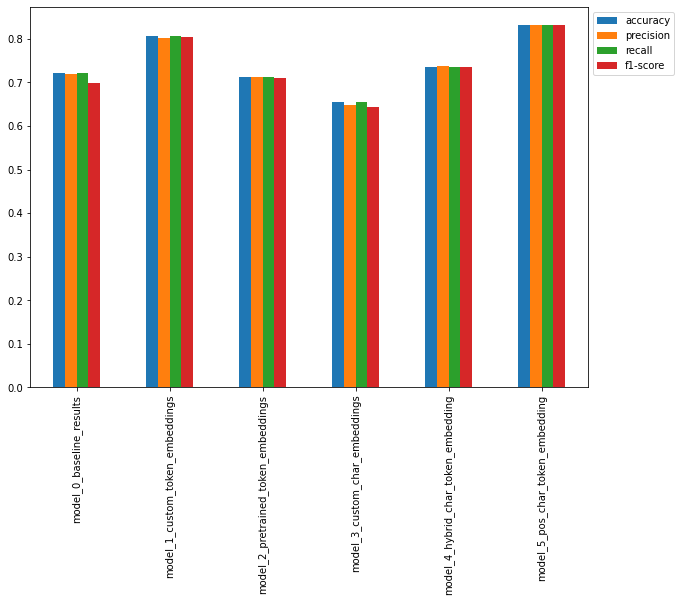

In [190]:
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<AxesSubplot:>

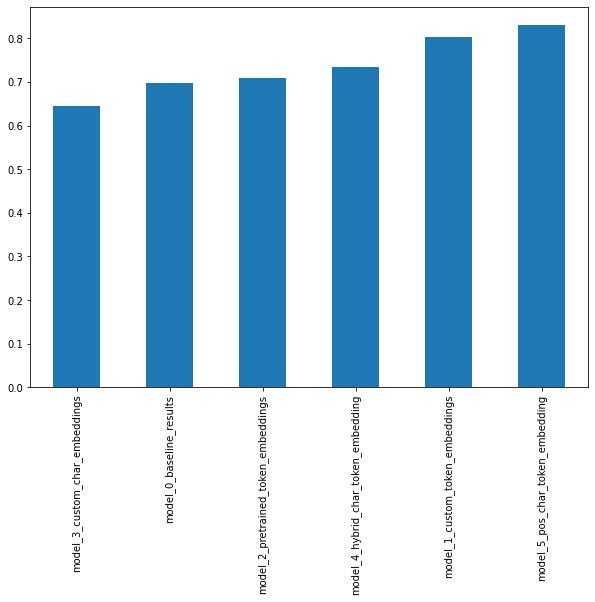

In [191]:
all_model_results.sort_values('f1-score', ascending=True)['f1-score'].plot(kind='bar', figsize=(10, 7))

In [236]:
# model_5.save('skimlit_tribrid_model.h5',save_format='tf')
tf.keras.models.save_model(model=model_5,filepath='skimlit_model',save_format='tf')

INFO:tensorflow:Assets written to: skimlit_model\assets


INFO:tensorflow:Assets written to: skimlit_model\assets


In [238]:
loaded_model = tf.keras.models.load_model('skimlit_model',custom_objects={'KerasLayer':hub.KerasLayer})

ValueError: Exception encountered when calling layer "forward_lstm_2" (type LSTM).

The mask that was passed in was tf.RaggedTensor(values=Tensor("Placeholder_2:0", shape=(None,), dtype=bool), row_splits=Tensor("Placeholder_3:0", shape=(None,), dtype=int64)), which cannot be applied to RaggedTensor inputs. Please make sure that there is no mask injected by upstream layers.

Call arguments received:
  • inputs=tf.RaggedTensor(values=Tensor("Placeholder:0", shape=(None, 25), dtype=float32), row_splits=Tensor("Placeholder_1:0", shape=(None,), dtype=int64))
  • mask=tf.RaggedTensor(values=Tensor("Placeholder_2:0", shape=(None,), dtype=bool), row_splits=Tensor("Placeholder_3:0", shape=(None,), dtype=int64))
  • training=None
  • initial_state=None